# Промышленность: исследование процесса обработки стали

## Задание

Вам поручили изучить характеристики процесса обработки стали. Для каждого значения столбца key найдите:

- Длительность времени между первым и последним замером температуры.
- Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.
- Количество запусков нагрева электродами.
- Среднее соотношение потребления активной и реактивной мощности.
- По всем полученным столбцам вычислите статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.

# Код проекта

## Предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
# удаляю Nan и партии в которых всего 1 измеренная температура
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=['Время замера'])
nan_temp_list = data_temp.query('Температура != Температура')['key'].to_list()
filtered_data_temp = data_temp.query('Температура == Температура').reset_index(drop=True)
temp_count_per_key = filtered_data_temp.groupby(['key'],as_index=False).count()
le_1_temp_list = temp_count_per_key.query('Температура <= 1')['key'].to_list()
filtered_data_temp = filtered_data_temp.query('key not in @nan_temp_list and key not in @le_1_temp_list')
filtered_data_temp.tail()

,key,Время замера,Температура
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0
12266,2499,2019-08-06 03:00:28,1603.0


In [3]:
# удаляю ключи партий аналогично таблице data_temp и считаю продолжительность нагрева в секундах
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=['Начало нагрева дугой','Конец нагрева дугой'])
filtered_data_arc = data_arc.query('key not in @nan_temp_list and key not in @le_1_temp_list')
filtered_data_arc['Продолжительность нагрева'] = (filtered_data_arc['Конец нагрева дугой'] - filtered_data_arc['Начало нагрева дугой'])
filtered_data_arc['Продолжительность нагрева'] = filtered_data_arc['Продолжительность нагрева'].dt.total_seconds()
filtered_data_arc.tail()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,41.0
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,312.0
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,205.0
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,295.0
11448,2499,2019-08-06 02:54:31,2019-08-06 02:55:42,0.312893,0.212472,71.0


In [4]:
# удаляю ключи партий аналогично таблицам data_temp и data_arc
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
filtered_data_gas = data_gas.query('key not in @nan_temp_list and key not in @le_1_temp_list')
filtered_data_gas.tail()

,key,Газ 1
2495,2498,14.953657
2496,2499,11.336151
2680,2683,0.338997
3197,3200,0.908588
3204,3207,1.074360


In [5]:
# выделяю начальные и конечные признаки по температуре, мощностям, нагреву и группирую по партиям
first_last_data_temp = filtered_data_temp.pivot_table(index=['key'], 
                                values=['Температура'], 
                                aggfunc={'Температура': ['first', 'last']}).reset_index()

first_last_data_arc = filtered_data_arc.pivot_table(index=['key'], 
                        values=['Активная мощность', 'Реактивная мощность', 'Продолжительность нагрева'],
                        aggfunc={'Активная мощность': ['first', 'last'], 'Реактивная мощность': ['first', 'last'], \
                                         'Продолжительность нагрева': ['first', 'last']})


print(first_last_data_temp.tail())
first_last_data_arc.tail()

       key Температура        
                 first    last
2470  2495      1570.0  1591.0
2471  2496      1554.0  1591.0
2472  2497      1571.0  1589.0
2473  2498      1591.0  1594.0
2474  2499      1569.0  1603.0


Активная мощность           Продолжительность нагрева         \
                 first      last                     first   last   
key                                                                 
2495          0.875021  0.435236                     207.0   99.0   
2496          0.393625  1.049800                     117.0  228.0   
2497          0.580983  0.796857                     156.0  206.0   
2498          1.162895  0.180213                     256.0   41.0   
2499          1.425867  0.312893                     312.0   71.0   

     Реактивная мощность            
                   first      last  
key                                 
2495            0.705281  0.304878  
2496            0.287355  0.701201  
2497            0.504512  0.645539  
2498            0.832519  0.116065  
2499            1.043338  0.212472

In [6]:
# создаю единую таблицу признаков
columns_list = ['Начальная температура', 'Конечная температура', 'Начальная акт. мощность', \
                'Конечная акт. мощность', 'Начальная продолж. нагрева',            \
                'Конечная продолж. нагрева', 'Начальная реакт. мощность',          \
                'Конечная реакт. мощность', 'Газ']

result_data = pd.merge(first_last_data_temp, first_last_data_arc, on='key').set_index('key')
result_data = pd.merge(result_data, data_gas, on='key').set_index('key')
result_data.columns = columns_list
result_data.head()

,Начальная температура,Конечная температура,Начальная акт. мощность,Конечная акт. мощность,Начальная продолж. нагрева,Конечная продолж. нагрева,Начальная реакт. мощность,Конечная реакт. мощность,Газ
key,,,,,,,,,
1,1571.0,1613.0,0.976059,0.692755,228.0,148.0,0.687084,0.414397,29.749986
2,1581.0,1602.0,0.438063,0.827743,137.0,210.0,0.283043,0.516874,12.555561
3,1596.0,1599.0,1.062053,0.250280,280.0,65.0,0.671494,0.155901,28.554793
4,1601.0,1625.0,0.875313,1.220955,207.0,278.0,0.614404,0.754719,18.841219
5,1576.0,1602.0,0.950026,0.267457,251.0,71.0,0.690523,0.181992,5.413692


## Исследовательский анализ данных

In [7]:
# функция для построения графиков распределения и матрицы корреляции
def build_charts(table, columns):
    sns.set(style="ticks")
    sns.pairplot(table[columns])
    plt.show()
    
    corr_1 = table[table.columns].corr()

    fig, ax = plt.subplots(figsize=(10,10))

    ax = sns.heatmap(
        corr_1,
        vmin=0, vmax=1,
        linewidths=.5,
        annot=True,
        square=True
)
    
start_columns = ['Начальная температура', 'Начальная акт. мощность', 'Начальная продолж. нагрева', \
                 'Начальная реакт. мощность', 'Газ']
end_columns = ['Конечная температура', 'Конечная акт. мощность', 'Конечная продолж. нагрева', \
                 'Конечная реакт. мощность', 'Газ']

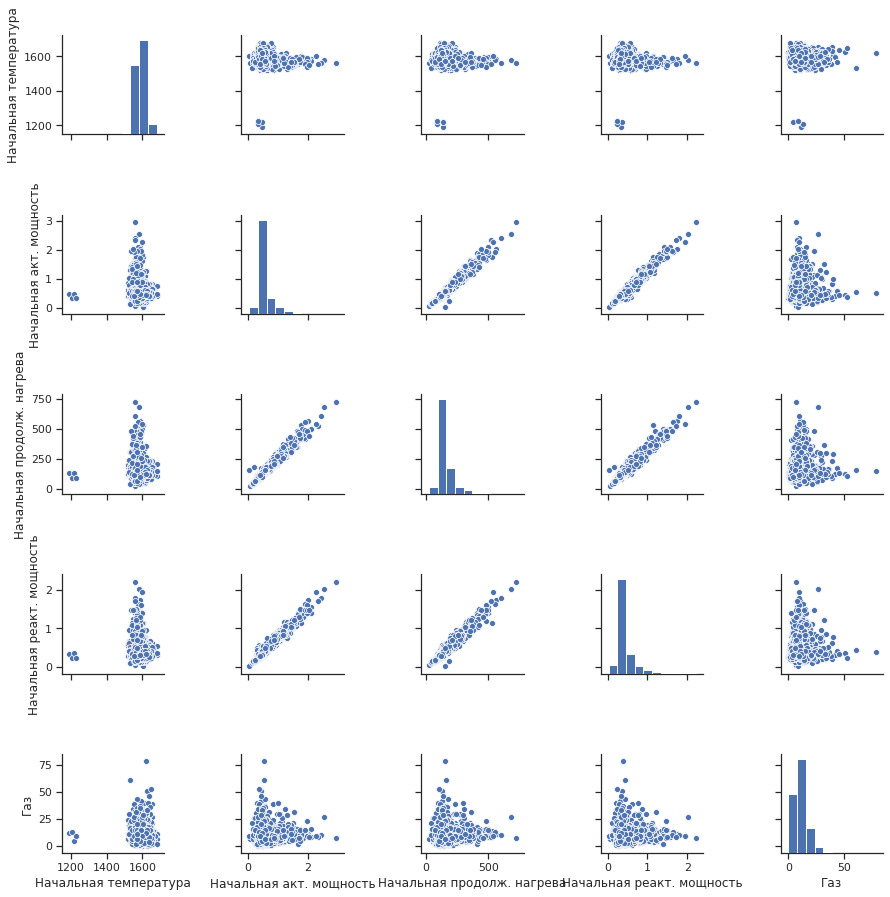

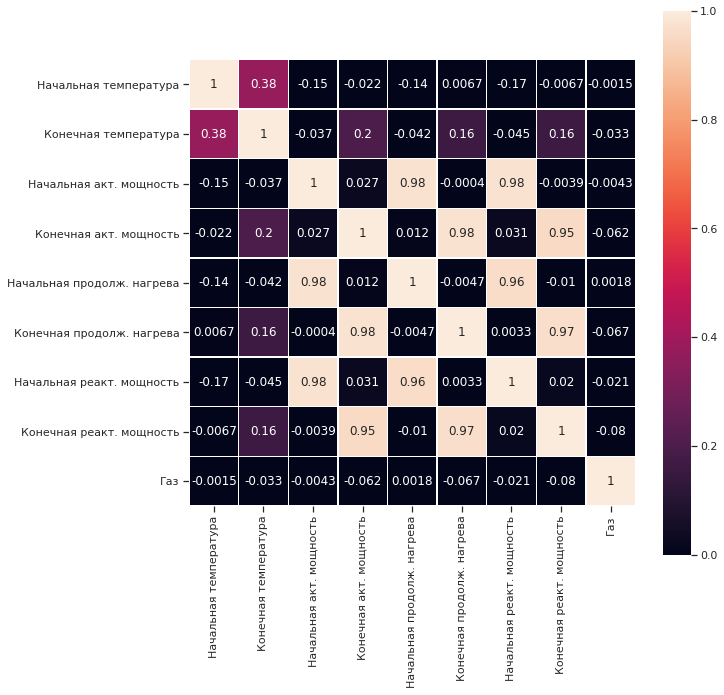

In [8]:
# для начальных признаков
build_charts(result_data, start_columns)

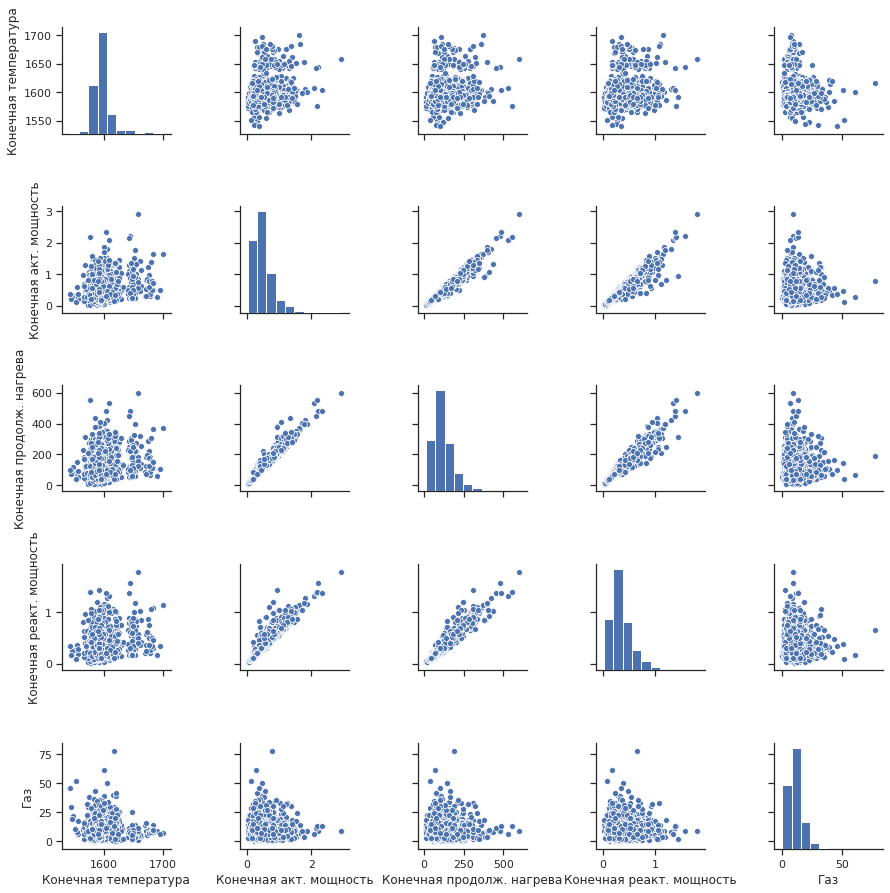

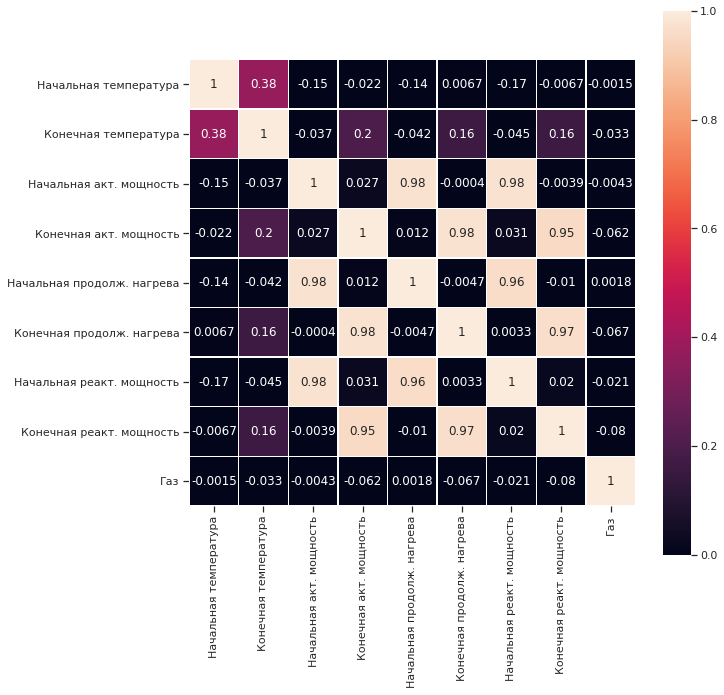

In [9]:
# для итоговых признаков
build_charts(result_data, end_columns)

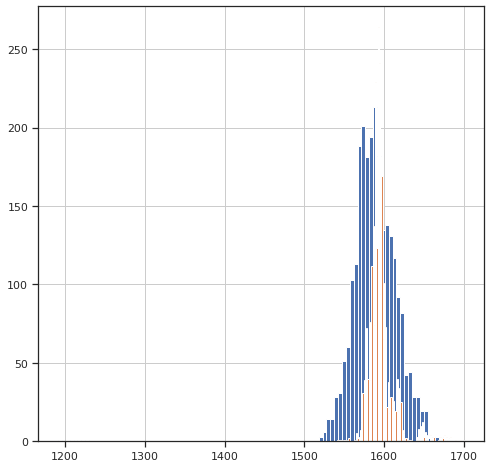

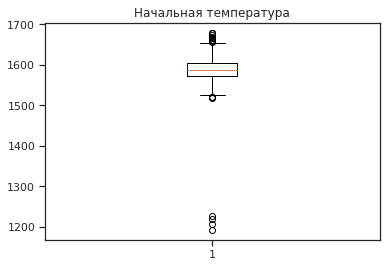

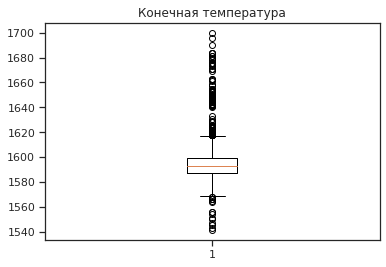

In [10]:
result_data['Начальная температура'].hist(bins=100, figsize=(8,8))
result_data['Конечная температура'].hist(bins=100, figsize=(8,8))
plt.show()
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.set_title('Начальная температура')
ax1.boxplot(result_data['Начальная температура'])
plt.show()
fig2, ax2 = plt.subplots()
ax2.set_title('Конечная температура')
ax2.boxplot(result_data['Конечная температура'])
plt.show()

In [11]:
result_data = result_data[result_data['Начальная температура'] > 1530]
result_data = result_data[result_data['Начальная температура'] < 1640]
result_data = result_data[result_data['Конечная температура'] > 1575]
result_data = result_data[result_data['Конечная температура'] < 1610]

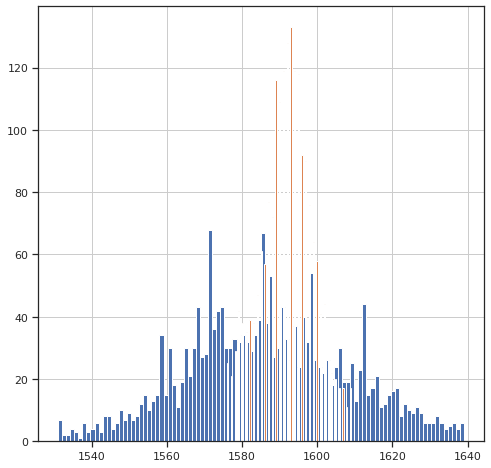

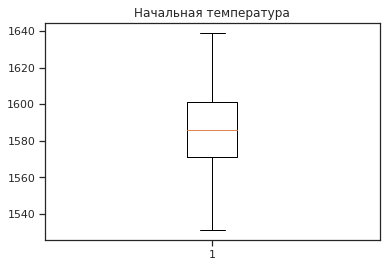

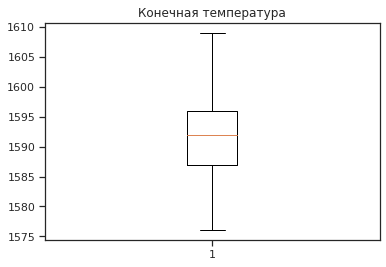

In [12]:
result_data['Начальная температура'].hist(bins=100, figsize=(8,8))
result_data['Конечная температура'].hist(bins=100, figsize=(8,8))
plt.show()
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.set_title('Начальная температура')
ax1.boxplot(result_data['Начальная температура'])
plt.show()
fig2, ax2 = plt.subplots()
ax2.set_title('Конечная температура')
ax2.boxplot(result_data['Конечная температура'])
plt.show()

### Выводы:

1. Активная и реактивная мощности сильно коррелируют с продолжительностью нагрева - между ними линейная зависимость
2. Есть слабая положительная корреляция между начальной и конечной температурой нагрева 
3. Очень слабая положительная корреляция между конечными активной-реактивной мощностями и конечной продолжительностью нагрева
4. Есть немного выбросов в начальной и конечной температурах, которые можно исключить из итоговой таблицы

## Построение модели

 #### 1. Линейная регрессия

In [13]:
def data_split(table):
    data_train, data_valid = train_test_split(table, test_size=0.25, random_state=110297)
    print('shape data_train:', data_train.shape, 'shape data_valid:', data_valid.shape)
    return data_train, data_valid

data_train_1, data_valid_1 = data_split(result_data)

def features_target_split(table):
    features = table.drop(['Конечная температура'], axis=1)
    target = table['Конечная температура']
    return features, target

features_train_1, target_train_1 = features_target_split(data_train_1)
features_valid_1, target_valid_1 = features_target_split(data_valid_1)

shape data_train: (1513, 9) shape data_valid: (505, 9)


MAE = 5.39252019191662


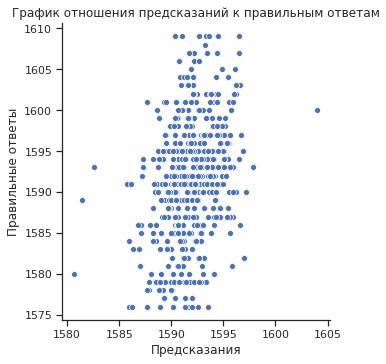

In [14]:
def teach_linear_regression(features_train, target_train, features_valid, target_valid):
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_valid)
    
    d = {'Предсказания': predictions, 'Правильные ответы': target_valid}
    predict = pd.DataFrame(data=d)
    
    mae = mean_absolute_error(target_valid, predictions)
    print("MAE =", mae)

    
    sns.relplot(x="Предсказания", 
                y="Правильные ответы",
                data=predict
               )
    plt.title(f'График отношения предсказаний к правильным ответам')
    plt.show()

    return predict

lr_model = teach_linear_regression(features_train_1, target_train_1, features_valid_1, target_valid_1)

#### 2. Градиентный бустинг

In [15]:
features_train_1.columns = ['1', '2', '3', '4', '5', '6', '7', '8']
features_valid_1.columns = ['1', '2', '3', '4', '5', '6', '7', '8']

In [16]:
%%time

lgb_train = lgb.Dataset(features_train_1, target_train_1)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'min_split_gain': 1,
    'n_estimators': 100,
    'metric': 'mae',
    'num_leaves': 31,
    'max_depth': 2,
    'learning_rate': 0.1,
    'verbose': 0,
    'random_state': '110297'
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_train,
                early_stopping_rounds=50,
               )

print('Saving model...')

Starting training...
[1]	training's l1: 5.48427
Training until validation scores don't improve for 50 rounds
[2]	training's l1: 5.4612
[3]	training's l1: 5.44207
[4]	training's l1: 5.42487
[5]	training's l1: 5.40996
[6]	training's l1: 5.39828
[7]	training's l1: 5.38347
[8]	training's l1: 5.36492
[9]	training's l1: 5.35207
[10]	training's l1: 5.34091
[11]	training's l1: 5.3282
[12]	training's l1: 5.31647
[13]	training's l1: 5.30799
[14]	training's l1: 5.30029
[15]	training's l1: 5.29381
[16]	training's l1: 5.28523
[17]	training's l1: 5.27718
[18]	training's l1: 5.2721
[19]	training's l1: 5.26106
[20]	training's l1: 5.25498
[21]	training's l1: 5.24583
[22]	training's l1: 5.23745
[23]	training's l1: 5.23513
[24]	training's l1: 5.22394
[25]	training's l1: 5.21337
[26]	training's l1: 5.20939
[27]	training's l1: 5.20616
[28]	training's l1: 5.199
[29]	training's l1: 5.1937
[30]	training's l1: 5.18921
[31]	training's l1: 5.18269
[32]	training's l1: 5.1773
[33]	training's l1: 5.17207
[34]	train

In [17]:
%%time

print('Starting predicting...')
prediction = gbm.predict(features_valid_1, num_iteration=gbm.best_iteration)
print('The mae of prediction is:', mean_absolute_error(target_valid_1, prediction)) 

Starting predicting...
The mae of prediction is: 5.358242458139683
CPU times: user 46.7 ms, sys: 4.75 ms, total: 51.4 ms
Wall time: 14.6 ms


## Выводы

Получилось достигнуть MAE = 5.35 градиентным бустингом, и немногим выше MAE = 5.39 линейной регрессией.

# Отчет по проекту

#### Какие пункты плана были выполнены
1. Подготовила данные. Выбрала необходимые данные из таблиц, избавилась от пропусков, удалила некорректные данные, а также аномалии, на выходе получилась единая таблица с необходимыми признаками сгруппированная по партиям: одна строка - одна партия.
2. Для подготовленных данных провела исследовательский анализ, построила графики распределения и зависимостей, также построила матрицы корреляций. Выявила корреляции различной величины. Избавилась от найденных на графиках аномальных данных по конченой и начальной температурах.
3. Выделила целевой признак - конечную температуру партии. Выделила признаки для обученния в таблице `result_data`. Разделила датасет на тестовую и обучающую выборки. Обучила две модели: линейную регрессию, модель реегрессии с градиентным бустингом. Проверила качетсво модели с помощью показателя MAE.

#### Какие пункты плана НЕ были выполнены
Касательно одобреного плана были выполнены все пункты.

#### Какие трудности возникли
1. Возникли трудности с выбором данных для обучения модели.
2. Возникли трудности с полученнием необходимого качества модели, изначально MAE было в районе 8.7-9.


#### Как преодолела трудности
1. После получения уточнений от заказчика удалось исключить лишние данные и выявить целевой признак.
2. Удалось уменьшить показатель MAE за счет удаления выбросов в данных о конечной и начальной температурах.


#### Какие ключевые шаги в решении задачи выделила
1. Выбрать целевой и обучающие признаки 
2. Преобразовать их в единую таблицу без пропусков 
3. Найти зависимости между признаками
4. Избавится от статистических выбросов
5. Обучить обычную модель линейной регрессии
6. Обучить модель линейной регрессии с градиеннтным бустингом

#### Моя итоговая модель и её качество
Модель в текущей реализации сможет помочь бизнесу, получилось достигнуть MAE = 5.35 с помощью линейной регрессии с градиентным бустингом.